In [33]:
PROJECT_NAME = 'densenet201'

# Import

In [34]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


In [35]:
import timm

In [36]:
try:
    import wandb
except:
    !pip install wandb
    import wandb

wandb.login()
# wandb.login(secret_value_0)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [37]:
import pandas as pd
import os
from pathlib import Path


import torch

from torch.utils.data import DataLoader

"""
Contains functions for training and testing a PyTorch model.
"""

from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [38]:
from dataset_helper import ImageFolderCustom
from model_engine import Engine
from helper_plot import plot_torch_hist

# Directory

In [39]:
data_path = Path('/kaggle/input/oc-dataset-1/patches')

In [40]:
image_dir = data_path / 'images'
train_df = pd.read_csv(data_path/'sabpatch_parsed_folders.csv')
train_ds = train_df[['path','lesion']]
test_df = pd.read_csv(data_path/'sabpatch_parsed_test.csv')
test_ds = test_df[['path','lesion']]

# Global Parameters

In [41]:
ALPHA = 0.0001 ## Learning Rate
EPOCH = 50  ## Epochs
BATCH_SIZE = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DROPOUT = 0.5
PATIENCE = 10

# MEAN = [0.485, 0.456, 0.406]
# STD = [0.229, 0.224, 0.225]

In [42]:
model = timm.create_model(
    'densenet201',
    pretrained=True,
    num_classes=3,  # remove classifier nn.Linear
    drop_rate = DROPOUT
)

data_config = timm.data.resolve_model_data_config(model)
train_transforms = timm.data.create_transform(**data_config, 
                                        is_training=True,
                                                                
)
test_transforms = timm.data.create_transform(**data_config, 
                                             is_training=False)

In [43]:
# import torchvision

In [44]:
# model = torchvision.models.mobilenetv3(pretrained=True)
# model

In [45]:
# feats_list = list(model.features)
# new_feats_list = []
# for feat in feats_list:
#     new_feats_list.append(feat)
#     if isinstance(feat, nn.Conv2d):
#         new_feats_list.append(nn.Dropout(p=0.5, inplace=True))

# # modify convolution layers
# model.features = nn.Sequential(*new_feats_list)


In [46]:
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), 
#                                       ratio=(0.75, 1.3333), interpolation=transforms.InterpolationMode.BICUBIC),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ColorJitter(brightness=(0.6, 1.4), 
#                 contrast=(0.6, 1.4), 
#                 saturation=(0.6, 1.4), hue=0),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), 
#               std=([0.2290, 0.2240, 0.2250])),
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=([0.4850, 0.4560, 0.4060]), 
#               std=([0.2290, 0.2240, 0.2250])),
# ])

In [47]:
train_transforms

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [48]:
# from torch.utils.data import default_collate
# from torchvision.transforms import v2

# def collate_fn(batch):
#     return cutmix_or_mixup(*default_collate(batch))

# cutmix = v2.CutMix(num_classes=3)
# mixup = v2.MixUp(num_classes=3)
# cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [49]:
    train_data = ImageFolderCustom(targ_dir = image_dir,
                                          path_df = train_ds,
                                          transform= train_transforms)

    test_data = ImageFolderCustom(targ_dir = image_dir,
                                          path_df = test_ds,
                                          transform= test_transforms)
    
    classes, class_to_idx = train_data.find_classes()

/kaggle/usr/lib/dataset_helper/dataset_helper.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.img_df['path'] = self.check_path(targ_dir)


In [50]:
train_dataloader = DataLoader(dataset=train_data, # use custom created train Dataset
                                        batch_size=BATCH_SIZE, # how many samples per batch?
                                        num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                        shuffle=True, # shuffle the data?
                                        )

test_dataloader = DataLoader(dataset=test_data, # use custom created test Dataset
                                        batch_size=BATCH_SIZE,
                                        num_workers=0,
                                        shuffle=False) # don't usually need to shuffle testing data


In [51]:
    wandb.init(
    project=PROJECT_NAME,
    config={
            "epochs": EPOCH,
            "batch_size": BATCH_SIZE,
            "lr": ALPHA,
            "architecture": "CNN",
            "dropout": DROPOUT,
            "patience":PATIENCE,
            "model":'DenseNet201',
            })


test/test_acc,▁▅▆▇▇▃▇▅▇█▅
test/test_loss,▂▁▄▁▁▂▁█▁▁▄
train/epoch,▁▂▂▃▄▄▅▅▆▇▇█
train/train_acc,▃▁▂▄▅▇▆▇▆▇▆█
train/train_loss,▇█▇█▃▁▄▂▄▂▄▄
test/test_acc,0.4992
test/test_loss,103.05872
train/epoch,35.5
train/train_acc,0.53795
train/train_loss,35.17968


In [52]:
loss_fn = nn.CrossEntropyLoss(reduction='sum') # computes the cross entropy loss between input logits and target.

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
Engine = Engine(model=model, loss_fn=loss_fn, optimizer=optimizer, device=device, early_stopping=True , config = wandb.config, dirpath = '/kaggle/working/model_weights')
result = Engine.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader, epochs=EPOCH, verbose=True, patience=PATIENCE)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch 1/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 1/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 1 | train_loss: 25.0060 | train_acc: 0.6339 | test_loss: 18.8142 | test_acc: 0.7321


Epoch 2/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 2/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 2 | train_loss: 20.8679 | train_acc: 0.7082 | test_loss: 15.7061 | test_acc: 0.7656


Epoch 3/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 3/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 3 | train_loss: 18.1289 | train_acc: 0.7526 | test_loss: 14.7958 | test_acc: 0.8070


Epoch 4/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 4/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 4 | train_loss: 17.1026 | train_acc: 0.7723 | test_loss: 13.0121 | test_acc: 0.8309


Epoch 5/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 5/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 5 | train_loss: 14.8984 | train_acc: 0.7997 | test_loss: 10.9834 | test_acc: 0.8549


Epoch 6/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 6/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 6 | train_loss: 13.5536 | train_acc: 0.8195 | test_loss: 10.3081 | test_acc: 0.8724


Epoch 7/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 7/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 7 | train_loss: 12.9482 | train_acc: 0.8326 | test_loss: 9.9859 | test_acc: 0.8644


Epoch 8/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 8/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 8 | train_loss: 12.1608 | train_acc: 0.8450 | test_loss: 11.1479 | test_acc: 0.8437
Early stopping counter: 1 out of 10


Epoch 9/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 9/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 9 | train_loss: 11.4664 | train_acc: 0.8492 | test_loss: 9.5127 | test_acc: 0.8836


Epoch 10/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 10/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 10 | train_loss: 10.6170 | train_acc: 0.8616 | test_loss: 11.2159 | test_acc: 0.8804
Early stopping counter: 1 out of 10


Epoch 11/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 11/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 11 | train_loss: 9.3962 | train_acc: 0.8823 | test_loss: 11.3155 | test_acc: 0.8644
Early stopping counter: 2 out of 10


Epoch 12/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 12/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 12 | train_loss: 9.4382 | train_acc: 0.8852 | test_loss: 9.6317 | test_acc: 0.8931
Early stopping counter: 3 out of 10


Epoch 13/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 13/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 13 | train_loss: 9.3645 | train_acc: 0.8884 | test_loss: 10.7636 | test_acc: 0.8724
Early stopping counter: 4 out of 10


Epoch 14/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 14/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 14 | train_loss: 8.5737 | train_acc: 0.8903 | test_loss: 9.1416 | test_acc: 0.8788


Epoch 15/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 15/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 15 | train_loss: 8.3928 | train_acc: 0.8967 | test_loss: 10.3208 | test_acc: 0.8724
Early stopping counter: 1 out of 10


Epoch 16/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 16/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 16 | train_loss: 8.3520 | train_acc: 0.9015 | test_loss: 9.5145 | test_acc: 0.8884
Early stopping counter: 2 out of 10


Epoch 17/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 17/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 17 | train_loss: 7.7858 | train_acc: 0.9047 | test_loss: 9.2048 | test_acc: 0.8995
Early stopping counter: 3 out of 10


Epoch 18/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 18/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 18 | train_loss: 7.2847 | train_acc: 0.9114 | test_loss: 9.1265 | test_acc: 0.8963


Epoch 19/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 19/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 19 | train_loss: 7.9476 | train_acc: 0.9043 | test_loss: 8.8590 | test_acc: 0.9011


Epoch 20/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 20/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 20 | train_loss: 6.6691 | train_acc: 0.9206 | test_loss: 8.1392 | test_acc: 0.9059


Epoch 21/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 21/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 21 | train_loss: 6.7936 | train_acc: 0.9177 | test_loss: 9.0856 | test_acc: 0.8900
Early stopping counter: 1 out of 10


Epoch 22/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 22/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 22 | train_loss: 6.7940 | train_acc: 0.9216 | test_loss: 9.9305 | test_acc: 0.8884
Early stopping counter: 2 out of 10


Epoch 23/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 23/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 23 | train_loss: 6.3160 | train_acc: 0.9247 | test_loss: 11.1706 | test_acc: 0.8724
Early stopping counter: 3 out of 10


Epoch 24/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 24/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 24 | train_loss: 5.9524 | train_acc: 0.9276 | test_loss: 10.5087 | test_acc: 0.8724
Early stopping counter: 4 out of 10


Epoch 25/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 25/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 25 | train_loss: 5.9416 | train_acc: 0.9251 | test_loss: 10.1279 | test_acc: 0.9043
Early stopping counter: 5 out of 10


Epoch 26/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 26/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 26 | train_loss: 6.5130 | train_acc: 0.9260 | test_loss: 10.1940 | test_acc: 0.9043
Early stopping counter: 6 out of 10


Epoch 27/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 27/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 27 | train_loss: 6.6498 | train_acc: 0.9187 | test_loss: 10.3732 | test_acc: 0.8915
Early stopping counter: 7 out of 10


Epoch 28/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 28/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 28 | train_loss: 6.1518 | train_acc: 0.9295 | test_loss: 9.7132 | test_acc: 0.8868
Early stopping counter: 8 out of 10


Epoch 29/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 29/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 29 | train_loss: 6.0774 | train_acc: 0.9270 | test_loss: 10.9475 | test_acc: 0.8963
Early stopping counter: 9 out of 10


Epoch 30/50:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 30/50:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch: 30 | train_loss: 5.2667 | train_acc: 0.9324 | test_loss: 9.8822 | test_acc: 0.9011
Early stopping counter: 10 out of 10
Early Stopping


test/test_acc,▁▂▄▅▆▇▆▅▇▇▆▇▇▇▇▇████▇▇▇▇██▇▇██
test/test_loss,█▆▅▄▃▂▂▃▂▃▃▂▃▂▂▂▂▂▁▁▂▂▃▃▂▂▂▂▃▂
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/train_acc,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇███████████
train/train_loss,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
test/test_acc,0.90112
test/test_loss,9.88221
train/epoch,53.5
train/train_acc,0.9324
train/train_loss,5.26669


[INFO] Total training time: 2624.122 seconds


In [53]:
result_df = pd.DataFrame(result)
# result_df.head()

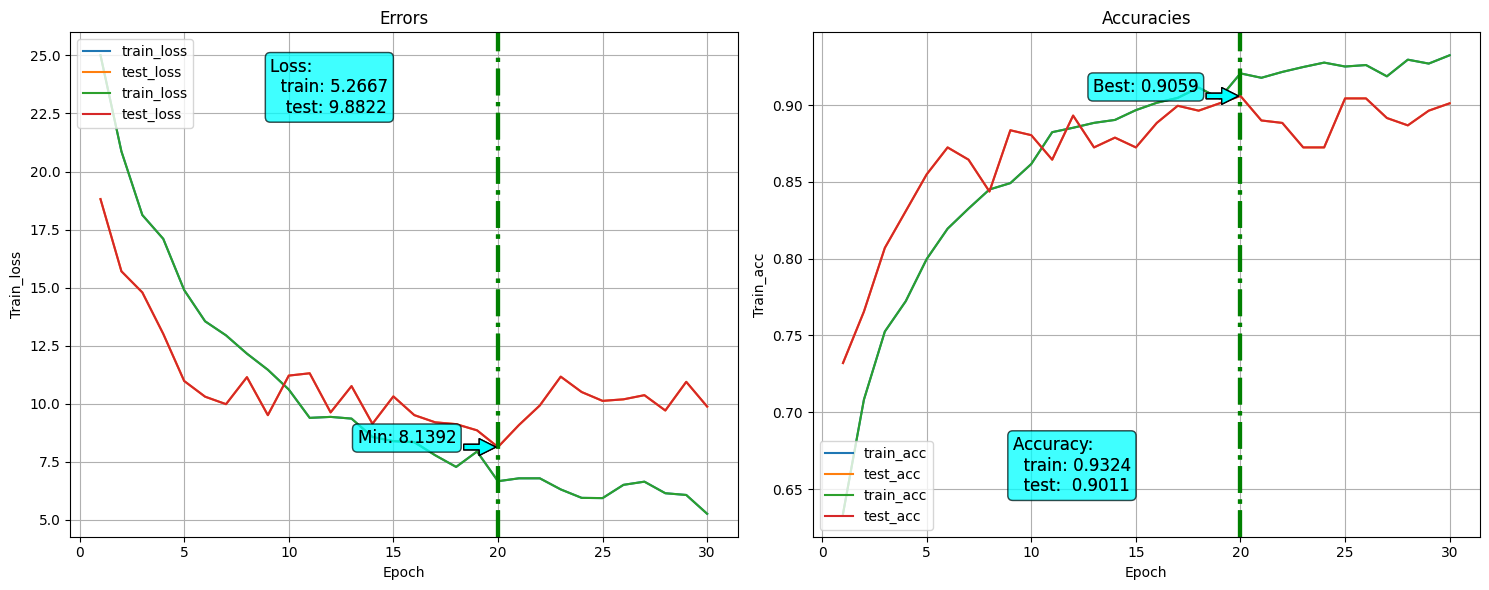

In [54]:
plot_torch_hist(result_df)

In [55]:
# train_transforms

In [1]:
!pip install torchview
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(32,3,224,224), expand_nested=True)
model_arc = model_graph.visual_graph

NameError: name 'model' is not defined